# Imports

In [1]:
import os
import pydotplus
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from IPython.display import Image

# Define Class

In [2]:
min_leaf = 2
class nepal_analysis(object):
    def __init__(self, condition):
        self.condition = condition
        data = pd.read_csv('Data/simplified_master.csv', index_col='Unnamed: 0')
        self.df = data.rename(columns= lambda x: x.replace(
                ' ', '').replace('/', '').replace('-', '').replace(
                '(', '').replace(')', '').replace('%', '').replace(
                '<', '').replace('\n', ''))        
        self.X = self.df.drop(self.df.columns[range(20, 43)], axis=1)
        self.X_sim = self.df.drop(self.df.columns[range (15) + range(20, 42)], axis=1)
        self.Y = self.df[self.condition]
    
    def simplified_rfr(self):
        try:
            rfr_sim = RandomForestRegressor(oob_score=True, random_state=1, min_samples_leaf=min_leaf)
#             gs = GridSearchCV(estimator=rfr_sim, param_grid={'max_leaf_nodes': range(5, 20)})
#             gs.fit(self.X_sim, self.Y)
#             self.rfr_sim = gs.best_estimator_
            self.rfr_sim = rfr_sim.fit(self.X_sim, self.Y)
            Y_sim_rfr_sig = filter(lambda x: x[1] > 0,
                                   sorted(zip(self.X_sim.columns,
                                              [round (i, 4) for i in self.rfr_sim.feature_importances_]
                                             ), key=lambda x: x[1], reverse=True))

            Y_sim_rfr_mse = pd.DataFrame()
            Y_sim_rfr_mse['Obs'] = self.Y
            Y_sim_rfr_mse['Pred'] = self.rfr_sim.predict(self.X_sim)
            Y_sim_rfr_mse['Diff'] = Y_sim_rfr_mse['Obs'] - Y_sim_rfr_mse['Pred']
            Y_sim_rfr_mse['DiffSqr'] = Y_sim_rfr_mse['Diff'] ** 2

            return ('Random Forest Score: {}'.format(self.rfr_sim.score(self.X_sim, self.Y)),
                    'OOB Score: {}'.format(self.rfr_sim.oob_score_),
                    Y_sim_rfr_sig, Y_sim_rfr_mse)
        except:
            return ['NO SIGNIFICANT FEATURES IN RFR',
                    'NO SIGNIFICANT FEATURES IN RFR', 
                    'NO SIGNIFICANT FEATURES IN RFR']
    
    def simplified_dtr(self, width):
        dtr_sim = DecisionTreeRegressor(random_state=1, min_samples_leaf=min_leaf)
        gs = GridSearchCV(estimator=dtr_sim, param_grid={'max_leaf_nodes': range(5, 20)})
        gs.fit(self.X_sim, self.Y)
        self.best_dtr_sim = gs.best_estimator_
        
        dot_data = export_graphviz(
            self.best_dtr_sim, feature_names=self.X_sim.columns,
            out_file=None, filled=True, rounded=True,
            special_characters=True)  
        graph = pydotplus.graph_from_dot_data(dot_data)  
        self.sim_dtr_img = Image(graph.create_png(), width=width) 
        
        Y_sim_dtr_mse = pd.DataFrame()
        Y_sim_dtr_mse['Obs'] = self.Y
        Y_sim_dtr_mse['Pred'] = self.best_dtr_sim.predict(self.X_sim)
        Y_sim_dtr_mse['Diff'] = Y_sim_dtr_mse['Obs'] - Y_sim_dtr_mse['Pred']
        Y_sim_dtr_mse['DiffSqr'] = Y_sim_dtr_mse['Diff'] ** 2
    
        return ('Decision Tree Score: {}'.format(self.best_dtr_sim.score(self.X_sim, self.Y)),
                self.sim_dtr_img, Y_sim_dtr_mse)
    
    def full_rfr(self):
        try:
            rfr = RandomForestRegressor(oob_score=True, random_state=1, min_samples_leaf=min_leaf)
#             gs = GridSearchCV(estimator=rfr_sim, param_grid={'max_leaf_nodes': range(5, 20)})
#             gs.fit(self.X, self.Y)
#             self.rfr = gs.best_estimator_
            self.rfr = rfr.fit(self.X, self.Y)
            self.Y_rfr_sig = filter(lambda x: x[1] > 0,
                                    sorted(zip(self.X.columns,
                                               [round (i, 4) for i in self.rfr.feature_importances_]
                                              ), key=lambda x: x[1], reverse=True))

            Y_rfr_mse = pd.DataFrame()
            Y_rfr_mse['Obs'] = self.Y
            Y_rfr_mse['Pred'] = self.rfr.predict(self.X)
            Y_rfr_mse['Diff'] = Y_rfr_mse['Obs'] - Y_rfr_mse['Pred']
            Y_rfr_mse['DiffSqr'] = Y_rfr_mse['Diff'] ** 2

            return('Random Forest Score: {}'.format(self.rfr.score(self.X, self.Y)),
                    'OOB Score: {}'.format(self.rfr.oob_score_),
                    self.Y_rfr_sig, Y_rfr_mse)
        except:
            return ['NO SIGNIFICANT FEATURES IN RFR',
                    'NO SIGNIFICANT FEATURES IN RFR', 
                    'NO SIGNIFICANT FEATURES IN RFR']

    def full_dtr_from_rfr(self, width):
        try:
            X_sig_for_y = self.X[map(lambda x: x[0], self.Y_rfr_sig)]
            dtr = DecisionTreeRegressor(random_state=1, min_samples_leaf=min_leaf)
            gs = GridSearchCV(estimator=dtr, param_grid={'max_leaf_nodes': range(5, 20)})
            gs.fit(X_sig_for_y, self.Y)
            best_dtr = gs.best_estimator_

            dot_data = export_graphviz(
                best_dtr, feature_names=X_sig_for_y.columns,
                out_file=None, filled=True, rounded=True,
                special_characters=True)  
            graph = pydotplus.graph_from_dot_data(dot_data) 
            self.dtr_img = Image(graph.create_png(), width=width)

            Y_dtr_mse = pd.DataFrame()
            Y_dtr_mse['Obs'] = self.Y
            Y_dtr_mse['Pred'] = best_dtr.predict(X_sig_for_y)
            Y_dtr_mse['Diff'] = Y_dtr_mse['Obs'] - Y_dtr_mse['Pred']
            Y_dtr_mse['DiffSqr'] = Y_dtr_mse['Diff'] ** 2

            return ('Decision Tree Score: {}'.format(best_dtr.score(X_sig_for_y, self.Y)),
                    self.dtr_img, Y_dtr_mse)
        except:
            return ['NO SIGNIFICANT FEATURES IN RFR',
                    'NO SIGNIFICANT FEATURES IN RFR', 
                    'NO SIGNIFICANT FEATURES IN RFR']

# Run For Any Condition

Mumps
Simplified data:
Random Forest Score: 0.803094886327
OOB Score: 0.233702639429
Decision Tree Score: 0.75998685079



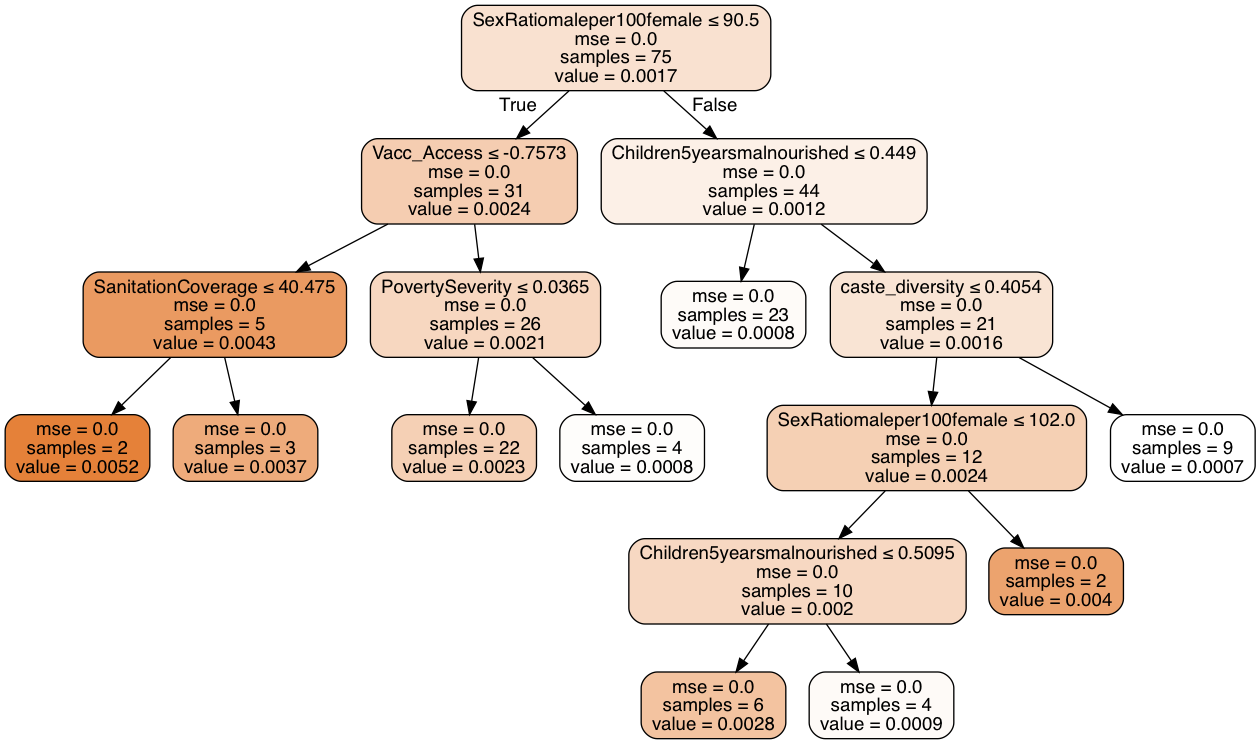

In [3]:
# POSSIBLE CONDITIONS:
list_of_conditions = [
    u'ConfirmedMeningitis3', u'HIVAIDS3', u'Leprosy3', u'STDSTI3',
    u'AcuteFlacidParalysis', u'Chickenpox', u'Diptheria', u'HepatatisB',
    u'Measles', u'Mumps', u'NeonatalTetanus', u'Rubella', u'Tetanus',
    u'Tuberculosis', u'Whoopingcough', u'Alcoholism', u'AnxietyNeurosis',
    u'ConversivedisorderHysteria',u'Depression', u'Epilesy', u'Mentalretardation',
    u'Psychosis']

condition = list_of_conditions[9] # Edit this to any condition name in data.
print condition

analysis = nepal_analysis(condition)
sim_rfr = analysis.simplified_rfr() # Create Random Forest Regressor on simplified data.
sim_dtr = analysis.simplified_dtr(600) # Create Decision Tree Regressor on simplified data.
full_rfr = analysis.full_rfr()
full_dtr = analysis.full_dtr_from_rfr(600)

print 'Simplified data:\n{0}\n{1}\n{2}\n'.format(sim_rfr[0], sim_rfr[1], sim_dtr[0])
sim_dtr[1]

Full data:
Random Forest Score: 0.821747706803
OOB Score: 0.228267816456
Decision Tree Score: 0.5818054443



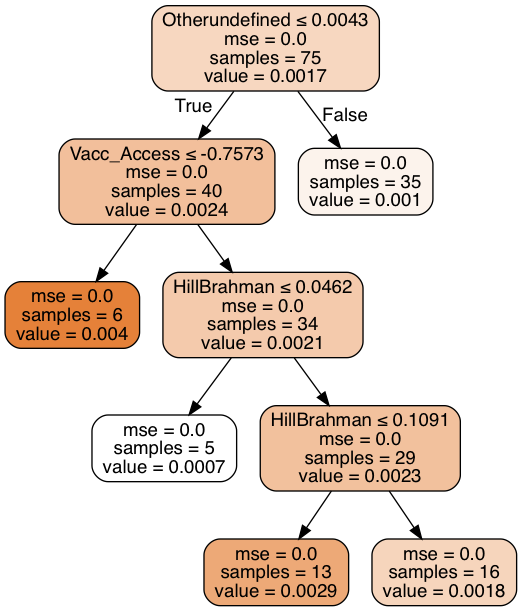

In [4]:
print 'Full data:\n{0}\n{1}\n{2}\n'.format(full_rfr[0], full_rfr[1], full_dtr[0])
full_dtr[1]

In [7]:
analysis.X.columns

Index([u'Foreigner', u'HillBrahman', u'HillChhetree', u'HillDalit',
       u'MadhesiBrahmanChhetree', u'MadhesiDalit', u'MadhesiOtherOCA',
       u'MadhesiOtherOCB', u'MtnHillJanajatiA', u'MtnHillJanajatiB',
       u'Musalman', u'Newar', u'OtherMPB', u'Otherundefined', u'TaraiJanajati',
       u'PovertySeverity', u'Adultilliteracyrate',
       u'Children5yearsmalnourished', u'SanitationCoverage',
       u'SexRatiomaleper100female', u'Vacc_Access'],
      dtype='object')